<a target="_blank" href="https://colab.research.google.com/github/starccato/starccato_jax/blob/main/docs/example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


# Example 

## Train VAE

In [ ]:
%load_ext autoreload
%autoreload 2

! pip install starccato_jax starccato_sampler -q

In [2]:
import starccato_jax
import starccato_sampler

print(f"starccato_jax version: {starccato_jax.__version__}")
print(f"starccato_sampler version: {starccato_sampler.__version__}")

starccato_jax version: 0.1.14.dev9+g86ee43d.d20250513
starccato_sampler version: 0.0.7.dev2+g2220781


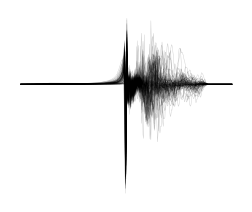

In [4]:
from starccato_jax.data import TrainValData
import matplotlib.pyplot as plt
import os

HERE = os.getcwd()
model_savedir = f"{HERE}/model_out"
os.makedirs(model_savedir, exist_ok=True)

data = TrainValData.load()

plt.figure(figsize=(3, 2.5))
for i in range(100):
    plt.plot(data.combined[i], color="k", lw=0.3, alpha=0.2)
plt.axis("off")
plt.savefig(f"{model_savedir}/training_data.png")

![](model_out/training_data.png)

In [9]:
from starccato_jax import Config, StarccatoVAE
import os

model_savedir = "model_out"
os.makedirs(model_savedir, exist_ok=True)

RETRAIN = False

if RETRAIN:
    config = Config(latent_dim=16, epochs=300, cyclical_annealing_cycles=0)
    starccato_vae = StarccatoVAE.train(
        model_dir=model_savedir,
        config=config,
        plot_every=50,
    )
else:
    starccato_vae = StarccatoVAE()

[05/14/25 12:10:44] WARNING  Every epoch will discard 3/1411 training samples due to batch size 64     ]8;id=31570;file:///Users/avaj0001/Documents/projects/starccato/starccato_jax/src/starccato_jax/vae/config.py\config.py]8;;\:]8;id=519246;file:///Users/avaj0001/Documents/projects/starccato/starccato_jax/src/starccato_jax/vae/config.py#53\53]8;;\

|                     |          |
|---------------------|----------|
| **Loss**            |  ![loss] |  
| **Reconstructions** | ![reconstructions] | 

[loss]: model_out/loss.png
[reconstructions]: model_out/reconstructions.png

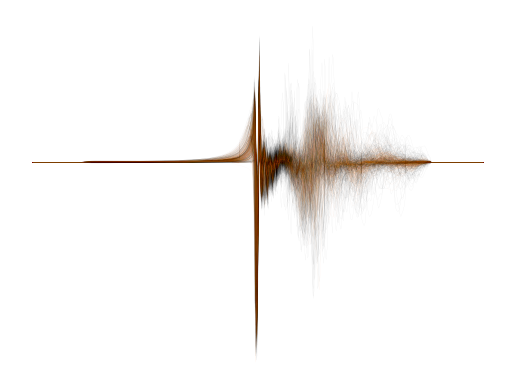

In [10]:
import jax

n = len(data.val)
zs = jax.random.normal(jax.random.PRNGKey(0), (n, starccato_vae.latent_dim))

generated_signal = starccato_vae.generate(z=zs)
for i in range(n):
    kwgs = dict(lw=0.1, alpha=0.1)
    plt.plot(generated_signal[i], color="tab:orange", **kwgs)
    plt.plot(data.val[i], color="k", **kwgs)
plt.axis("off")
plt.savefig(f"{model_savedir}/generated_signal.png")

![](model_out/generated_signal.png)

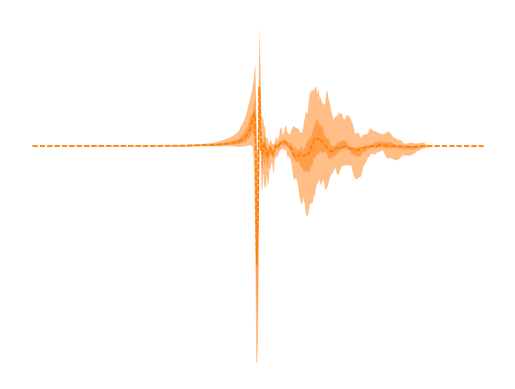

In [11]:
fig, ax = plt.subplots()
starccato_vae.plot(ax, n=100, ci=0.95)
starccato_vae.plot(ax, n=100, ci=0.5)
plt.axis("off")
plt.savefig(f"{model_savedir}/vae_plot.png")

![](model_out/vae_plot.png)

## MCMC on one validation dataset

[05/14/25 12:24:21] WARNING  Every epoch will discard 3/1411 training samples due to batch size 64     ]8;id=368158;file:///Users/avaj0001/Documents/projects/starccato/starccato_jax/src/starccato_jax/vae/config.py\config.py]8;;\:]8;id=551840;file:///Users/avaj0001/Documents/projects/starccato/starccato_jax/src/starccato_jax/vae/config.py#53\53]8;;\

sample: 100%|██████████| 6000/6000 [00:06<00:00, 912.10it/s, 15 steps of size 3.94e-01. acc. prob=0.86] 


GA Log Z: -3.688e+01 +/- 4.278e-02 [Runtime: 0.019 s]


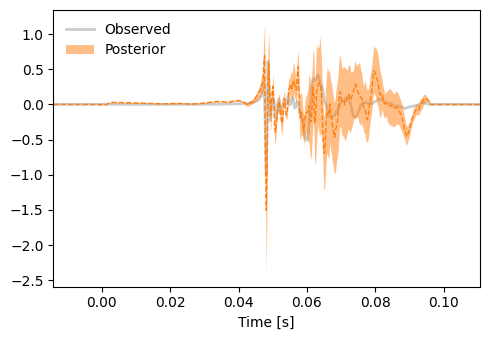

In [22]:
from starccato_sampler.sampler import sample
import numpy as np

injection = data.train[54]
# ensure that this y val is between -1 and 1
injection = injection / np.abs(injection).max()


mcmc_out = sample(
    injection,
    "default_ccsne",
    rng_int=0,
    outdir=f"{HERE}/out_mcmc",
    num_samples=4000,
    num_warmup=2000,
    num_chains=1,
)

In [23]:
import arviz as az

inf_data = az.from_numpyro(mcmc_out)
az.summary(inf_data, var_names=["z"])

arviz - WARNING - Shape validation failed: input_shape: (1, 4000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
z[0],0.123,0.219,-0.273,0.558,0.003,0.003,3947.0,3520.0,NaN
z[1],0.204,0.991,-1.666,1.985,0.014,0.016,4752.0,2724.0,NaN
z[2],1.229,0.195,0.872,1.592,0.004,0.003,2914.0,3273.0,NaN
z[3],-0.369,0.990,-2.377,1.369,0.015,0.014,4532.0,3097.0,NaN
z[4],-0.595,0.417,-1.372,0.177,0.007,0.005,4074.0,3186.0,NaN
z[5],0.471,0.934,-1.292,2.162,0.013,0.013,4896.0,3123.0,NaN
z[6],-0.109,0.239,-0.535,0.357,0.004,0.003,4537.0,2647.0,NaN
z[7],-0.457,0.442,-1.258,0.388,0.007,0.005,3999.0,3342.0,NaN
z[8],-0.316,0.143,-0.585,-0.054,0.002,0.002,3735.0,3092.0,NaN
z[9],0.134,0.971,-1.697,1.975,0.014,0.015,4614.0,3004.0,NaN


|            | |
|------------|--|
| **Trace**  | ![trace_plot][trace_plot] |
| **Corner** | ![corner_plot][corner_plot] |
| **CI**     | ![ci_plot][ci_plot] |


[ci_plot]: out_mcmc/ci_plot.png
[corner_plot]: out_mcmc/corner_plot.png
[trace_plot]: out_mcmc/trace_plot.png

sample: 100%|██████████| 4500/4500 [00:05<00:00, 798.65it/s, 15 steps of size 3.78e-01. acc. prob=0.88] 


GA Log Z: -3.593e+01 +/- 1.909e-02 [Runtime: 0.022 s]


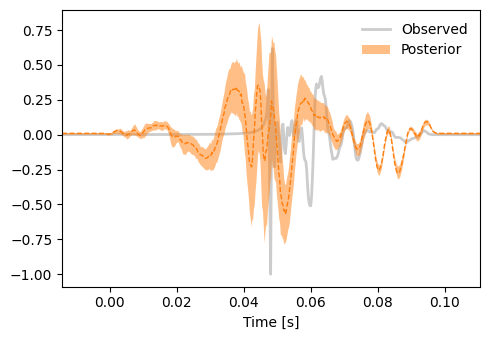

In [25]:
blip_mcmc_out = sample(
    injection,
    "default_blip",
    rng_int=0,
    outdir=f"{HERE}/out_mcmc_blip",
    num_samples=4000,
)